In [1]:
import numpy as np
import scipy.linalg
from control import dlqr
import matplotlib.pyplot as plt
import control
import time
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
def generate_perturbed_samples(A, N, epsilon, symmetric = None):
    """
    Generates N samples that are perturbed from matrix A,
    such that the maximum spectral norm difference between all pairs
    is less than epsilon.

    Parameters:
    A (np.ndarray): The original matrix.
    N (int): The number of samples to generate.
    epsilon (float): The maximum allowed spectral norm difference.
    flag (boolean): Check Q is symmetric.

    Returns:
    List[np.ndarray]: A list of perturbed samples.
    """
    # Compute the spectral norm of the original matrix
    norm_A = np.linalg.norm(A, ord=2)

    # Initialize a list to hold the perturbed samples
    perturbed_samples =[]
    perturbed_samples.append(A)

    # Generate N-1 perturbed samples
    for _ in range(N-1):
        while True:
            # Generate a random perturbation matrix
            P = np.random.randn(*A.shape)

            # If symmetric flag is set, make P a symmetric matrix
            if symmetric:
                P = (P + P.T) / 2

            # Scale the perturbation matrix to have a spectral norm of epsilon
            norm_P = np.linalg.norm(P, ord=2)
            P_scaled = (P / norm_P) * epsilon  * 0.6#*  (2/3 + 1/3 *(np.random.rand()  # Random scaling factor less than epsilon

            # Add the perturbation to the original matrix
            A_perturbed = A + P_scaled

            # Ensure that the new sample's spectral norm difference is less than epsilon
            if all(np.linalg.norm(A_perturbed - other_A, ord=2) < epsilon for other_A in perturbed_samples):
                perturbed_samples.append(A_perturbed)
                break  # The perturbed sample is valid, break the loop

    # perturbed_samples = perturbed_samples[1:]

    return perturbed_samples



def grad_zo(A, B, Q, R, K, U, r, x_0, N):
    nx = A.shape[0]
    nu = B.shape[1]
    K1 = []
    K2 = []
    cost_emp1 = []
    cost_emp2 = []
    grad = np.zeros((nu, nx))
    U1 = []

    for i in range(U.shape[0]):
        # Sample policies
        # Check stability
        #if check_stable(A, B, K + U[i]) == True and check_stable(A, B, K - U[i]) == True:
        K1.append(K + U[i])
        K2.append(K - U[i])
        U1.append(U[i])

        # Compute empirical cost
        x_0 = np.random.normal(0.5, 1e-3, size=(1,nx))[0]
        cost_emp1.append(generate_task.lqr_cost(A, B, Q, R, K1[-1], x_0, N))
        cost_emp2.append(generate_task.lqr_cost(A, B, Q, R, K2[-1], x_0, N))

    ns = len(cost_emp1)
    for i in range(ns):
        grad += ((nx * nu) / (2 * ns * (r ** 2))) * (cost_emp1[i] - cost_emp2[i]) * U1[i]

    return grad


def hessian_zo(A, B, Q, R, K, U, r, x_0, N):
    nx = A.shape[0]
    nu = B.shape[1]
    K1 = []
    K2 = []
    cost_emp1 = []
    cost_emp2 = []
    hess = np.zeros((nu, nu))
    U1 = []

    for i in range(U.shape[0]):
        # Sample policies
        # Check stability
        #if check_stable(A, B, K + U[i]) == True and check_stable(A, B, K - U[i]) == True:
        K1.append(K + U[i])
        K2.append(K - U[i])
        U1.append(U[i])

        x_0 = np.random.normal(0.5, 1e-3, size=(1,nx))[0]
        # Compute empirical cost
        cost_emp1.append(generate_task.lqr_cost(A, B, Q, R, K1[-1], x_0, N))
        cost_emp2.append(generate_task.lqr_cost(A, B, Q, R, K, x_0, N))

    ns = len(cost_emp1)
    for i in range(ns):
        U_i = U1[i] @ U1[i].T
        #hess += ((nu * nu) / (2 * ns * (r ** 2))) * (cost_emp1[i] - cost_emp2[i]) * (U_i - np.eye(U_i.shape[0]))
        hess += ((nu * nu) / (ns * (r ** 2))) * (cost_emp1[i] - cost_emp2[i]) * (U_i - np.eye(U_i.shape[0]))

    return hess

class generate_task:
    def __init__(self, A, B, Q, R, M = None, flag = None, param = None, N = None):
        """
        Initialize the Discrete Time State Space system with LQR cost function.

        Parameters:
        A (np.ndarray): State transition matrix.
        B (np.ndarray): Control matrix.
        Q (np.ndarray): State cost matrix.
        R (np.ndarray): Control cost matrix.
        M (int): Number of tasks.
        flag (str): 's': system heterogeneity, 'c': cost heterogeneity, 'sc': system & cost heterogeneity.
        param (list): [ep1, ep2], [ep3,ep4], [ep1,ep2,ep3,ep4]. Heterogeneity
        N (int): Horizon.
        """
        self.A = A
        self.B = B
        self.Q = Q
        self.R = R
        self.M = M

        if flag == 's':
            self.A_M = generate_perturbed_samples(A, M, param[0])
            self.B_M = generate_perturbed_samples(B, M, param[1])
            self.Q_M = [Q for _ in self.A_M]
            self.R_M = [R for _ in self.A_M]

        elif flag == 'c':
            self.Q_M = generate_perturbed_samples(Q, M, param[0], 1)
            self.R_M = generate_perturbed_samples(R, M, param[1], 1)
            self.A_M = [A for _ in self.Q_M]
            self.B_M = [B for _ in self.Q_M]

        else: # s & c
            self.A_M = generate_perturbed_samples(A, M, param[0])
            self.B_M = generate_perturbed_samples(B, M, param[1])
            self.Q_M = generate_perturbed_samples(Q, M, param[0], 1)
            self.R_M = generate_perturbed_samples(R, M, param[1], 1)

    def K_star(self):
        K = []
        for i, item in enumerate(self.A_M):
            k, _, _ = dlqr(item, self.B_M[i], self.Q_M[i], self.R_M[i])
            K.append(np.array(k))
        self.K_star = K

    @staticmethod
    def control_law(K, x_t):
        if K is None:
            raise ValueError("LQR solution not computed. Call K_star() first.")
        return -K @ x_t

    @staticmethod
    def simulate(A, B, N, x0):
        x_t = x0.copy()
        states = [x_t]
        # controls = []
        for i in range(N):
            u_t = generate_task.control_law(K, x_t)
            # controls.append(u_t)
            x_t = A @ x_t + B @ u_t
            states.append(x_t)
        return states   #, controls

    @staticmethod
    def lqr_cost(A, B, Q, R, K, x_0, N):
        """
        Computes the LQR cost for a given sequence of states up to a horizon N,
        using the state cost matrix Q, the control cost matrix R, and the
        feedback gain matrix K.

        Parameters:
        Q (np.ndarray): The state cost matrix.
        R (np.ndarray): The control cost matrix.
        K (np.ndarray): The feedback gain matrix.
        x_list (List[np.ndarray]): The list of state vectors.
        N (int): The horizon up to which to compute the cost.

        Returns:
        float: The computed LQR cost.
        """
    
        pk = Q.copy()
        for t in range(N + 1):
            pk = Q + K.T @ R @ K + (A - B @ K).T @ pk @ (A - B @ K)
        cost = x_0 @ pk @ x_0
        return cost

    def init_k(self, perturb, step):
        k, _, _ = dlqr(self.A, self.B, self.Q, self.R)
        k = np.array(k)
        noise = np.random.normal(0, 1, k.shape)

        # Normalize the noise vector so its norm is 1
        noise = (noise / np.linalg.norm(noise)) * perturb
        k_p = k + noise
        flag_k = check_stable(self.A ,self.B, k)
        while flag_k == False:
            flag_k = check_stable(self.A ,self.B, k + np.random.normal(0, perturb, k.shape))
        flag_task = False
      
        while flag_task == False:
            flag = []
            for i in range(len(self.A_M)):
                ki = k_p - step * grad_true(self.A_M[i], self.B_M[i], self.Q_M[i], self.R_M[i], k_p)
                flag.append(check_stable(self.A_M[i], self.B_M[i], ki))

            flag_task = all(flag)

        return k_p, k

    def C_star(self, x_0, N): # N - horizon
        C = []
        for i, item in enumerate(self.A_M):
            cost = generate_task.lqr_cost(item, self.B_M[i], self.Q_M[i], self.R_M[i], self.K_star[i], x_0, N)
            C.append(cost)
        return C

    def MAML(self, K, ita1, ita2):
        sum1 = np.zeros((K.shape))
        for i in range(len(self.A_M)):
            K_1 = K - ita2 * grad_true(self.A_M[i], self.B_M[i], self.Q_M[i], self.R_M[i], K)
            grad = grad_true(self.A_M[i], self.B_M[i], self.Q_M[i], self.R_M[i], K_1)
            hess = hessian_true(self.A_M[i], self.B_M[i], self.Q_M[i], self.R_M[i], K)
            hess = np.eye(hess.shape[0]) - ita2 * hess
            sum1 += hess@grad
        step = - ita1 * (1/self.M) * sum1
        K_MAML = K + step
        return K_MAML

    def MAML_ZO(self, K, ita1, ita2, r, sample, x_0, N):
        sum1 = np.zeros((K.shape))
        U = np.random.randn(sample, self.B.shape[1], self.A.shape[0])
        U_norms = np.linalg.norm(U, axis=(1, 2), keepdims=True)
        U = (U / U_norms)* r
    
        for i in range(len(self.A_M)):
            K_1 = K - ita2 * grad_zo(self.A_M[i], self.B_M[i], self.Q_M[i], self.R_M[i], K, U, r, x_0, N)
            grad = grad_zo(self.A_M[i], self.B_M[i], self.Q_M[i], self.R_M[i], K_1, U, r, x_0, N)
            hess = hessian_zo(self.A_M[i], self.B_M[i], self.Q_M[i], self.R_M[i], K, U, r, x_0, N)
            hess = np.eye(hess.shape[0]) - ita2 * hess
            sum1 += hess @ grad
        step = - ita1 * (1/self.M) * sum1
        K_MAML = K + step
        return K_MAML



    def C_MAML(self, K, x_0, N): # N - horizon
        C = []
        for i, item in enumerate(self.A_M):
            cost = generate_task.lqr_cost(item, self.B_M[i], self.Q_M[i], self.R_M[i], K, x_0, N)
            C.append(cost)
        return C

In [11]:
#MAML - Convergence - Modified Boeing system 


AA = np.array([[ 1.22,  0.03, -0.02, -0.32],
              [ 0.01,  4.7 ,  0.  ,  0.  ],
              [ 0.02, -0.06,  0.4 ,  0.  ],
              [ 0.01, -0.04,  0.72,  1.55]])
BB = np.array([[ 0.01,  0.99],
              [-3.44,  1.66],
              [-0.83,  0.44],
              [-0.47,  0.25]])
QQ = np.eye(4)
RR = np.eye(2)
nx = AA.shape[0]
nu = BB.shape[1]
eta = 0.8e-5
eta_l = 0.8e-5
x_0 = np.array([0.25,0.55,0.35,0.45])
iteration = 200
ep = [0.01,0.01]
horizon = 500
setting = 'sc'
M = 10
r = 0.01
sample = 20
a = generate_task(AA,BB,QQ,RR,M,setting,ep)

$\textbf{Checking the true heterogeneity:}$

In [12]:
norm_1 = []
norm_2 = []
norm_3 = []
norm_4 = []
for p in range(M):
    for s in range(M):
        norm_1.append(np.linalg.norm(a.A_M[p] - a.A_M[s]))
        norm_2.append(np.linalg.norm(a.B_M[p] - a.B_M[s]))
        norm_3.append(np.linalg.norm(a.Q_M[p] - a.Q_M[s]))
        norm_4.append(np.linalg.norm(a.R_M[p] - a.R_M[s]))

dis1 = ["eps1=", max(norm_1)]
dis2 = ["eps2=", max(norm_2)]
dis3 = ["eps3=", max(norm_3)]
dis4 = ["eps4=", max(norm_4)]

print(dis1)
print(dis2)
print(dis3)
print(dis4)

['eps1=', 0.012684987614522705]
['eps2=', 0.010377082543082368]
['eps3=', 0.01337854978460775]
['eps4=', 0.01176517174492921]


In [13]:
C_opt = [i for i in range(iteration)]
C_MAML_All = []

K_opt_nominal,_,_ = dlqr(AA, BB, QQ, RR)
x0 = x_0
C_opt = generate_task.lqr_cost(AA, BB, QQ, RR, K_opt_nominal,x_0, horizon)

#Perturbing K_opt_nominal to generate the initial controller 
# KK = K_opt_nominal + 0.22 * np.random.rand(nu, nx)
K0 = np.array([[ 0.61343269, -1.53543838,  0.30279836,  0.39631415],
              [ 0.88802018,  0.60382034, -0.14729954, -0.58220629]])
C1 = generate_task.lqr_cost(AA, BB, QQ, RR, K0,x_0, 1000)

In [14]:
a.C_MAML(K0, x0, horizon)

[22.546370377402766,
 24.920068210556988,
 31.528428172231163,
 22.416277673080664,
 23.025825591822745,
 31.556552624096298,
 18.783176508490257,
 23.688801354699027,
 22.88145809724977,
 20.287537455602877]

In [15]:
def MAML_LQR(a,K0,eta,eta_l,x0,horizon,r,sample,C1,C_opt,iteration):
    C_MAML_ZO = []
    KK = K0
    C_MAML_ZO.append((a.C_MAML(KK, x0, horizon)[0] - C_opt))
    print(f"Iteration: {0}, Normalized cost gap: {C_MAML_ZO[0]}")
    for n in range(iteration):
        start_time = time.time()
        K11 = a.MAML_ZO(KK,eta,eta_l, r, sample, x0, horizon)
        KK = K11
        end_time = time.time()
        C_MAML_ZO.append((a.C_MAML(KK, x0, horizon)[0] - C_opt))        
        print(f"Iteration: {n+1}, Normalized cost gap: {C_MAML_ZO[n+1]}, Time: {end_time - start_time}")
    return C_MAML_ZO, KK

In [17]:
[costs,K_N] = MAML_LQR(a,K0,eta,eta_l,x0,horizon,r,sample,C1,C_opt,iteration)

Iteration: 0, Normalized cost gap: 19.83157578520511
Iteration: 1, Normalized cost gap: 14.370591690681533, Time: 2.7507741451263428
Iteration: 2, Normalized cost gap: 9.686329360941912, Time: 2.741473913192749
Iteration: 3, Normalized cost gap: 6.871128118417256, Time: 2.760016918182373
Iteration: 4, Normalized cost gap: 5.852221827674017, Time: 2.7495908737182617
Iteration: 5, Normalized cost gap: 5.023331477972239, Time: 2.7336652278900146
Iteration: 6, Normalized cost gap: 4.134490048640434, Time: 2.768667221069336
Iteration: 7, Normalized cost gap: 3.778143817028588, Time: 2.7563600540161133
Iteration: 8, Normalized cost gap: 3.4891741911647918, Time: 2.7572450637817383
Iteration: 9, Normalized cost gap: 3.2790833195172917, Time: 2.755427837371826
Iteration: 10, Normalized cost gap: 3.174517104730242, Time: 2.7651400566101074
Iteration: 11, Normalized cost gap: 3.0646809068776557, Time: 2.7660601139068604
Iteration: 12, Normalized cost gap: 2.8928411669018717, Time: 2.777771949768

Iteration: 118, Normalized cost gap: 0.44663286091561627, Time: 2.849341869354248
Iteration: 119, Normalized cost gap: 0.4429599529753947, Time: 2.8159360885620117
Iteration: 120, Normalized cost gap: 0.438768292171023, Time: 2.827314853668213
Iteration: 121, Normalized cost gap: 0.43583441925914723, Time: 2.818605899810791
Iteration: 122, Normalized cost gap: 0.4301709549464814, Time: 2.829741954803467
Iteration: 123, Normalized cost gap: 0.4269146048934678, Time: 2.8182930946350098
Iteration: 124, Normalized cost gap: 0.42412385567249533, Time: 2.8168551921844482
Iteration: 125, Normalized cost gap: 0.4198469199935717, Time: 2.805375099182129
Iteration: 126, Normalized cost gap: 0.41565587459504894, Time: 2.8270437717437744
Iteration: 127, Normalized cost gap: 0.4138648364753763, Time: 2.8260512351989746
Iteration: 128, Normalized cost gap: 0.40950059275590434, Time: 2.825878143310547
Iteration: 129, Normalized cost gap: 0.4073728799631562, Time: 2.8280513286590576
Iteration: 130, No

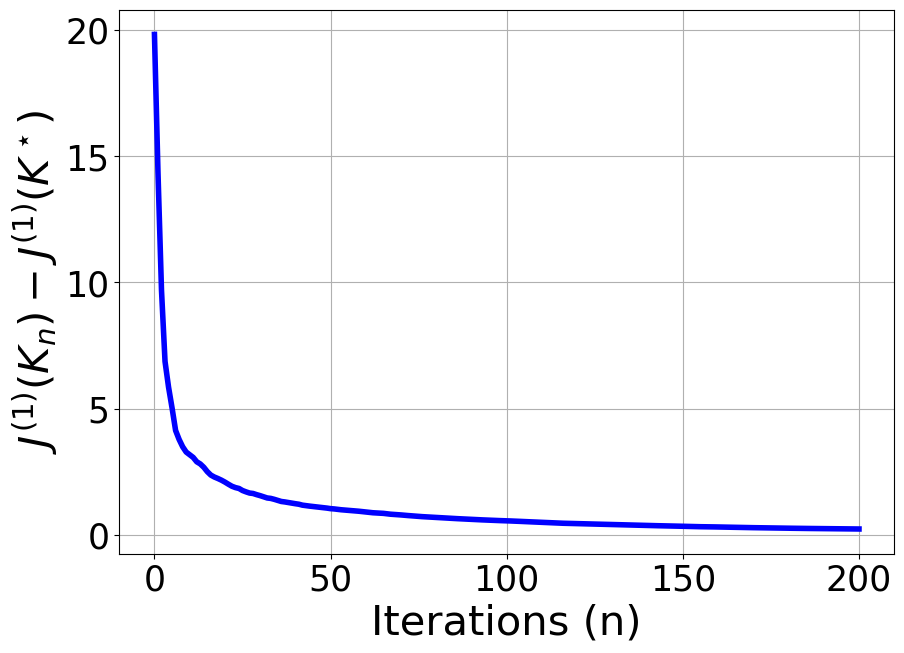

In [18]:
plt.figure(figsize=(10,8))

# Create a plot
plot_1=plt.plot(np.arange(200+1), costs, color='blue',linewidth=4)

plt.ylabel(r'$J^{(1)}(K_{n})-J^{(1)}(K^\star)$',fontsize=30)
plt.xlabel('Iterations (n)',fontsize=30)
plt.tick_params(axis='both', labelsize=25)

# Exclude the shading elements from the legend
plt.subplots_adjust(bottom=0.20)
plt.grid()
#Save different formats
plt.savefig('MAML_convergence.pdf')